In [1]:
import jax
jax.config.update("jax_enable_x64", True)


import matplotlib.pyplot as plt
from matplotlib import colormaps, colors

%matplotlib inline
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = "lower"
plt.rcParams["figure.dpi"] = 120

inferno = colormaps["inferno"]
seismic = colormaps["seismic"]

inferno.set_bad("k", 0.5)
seismic.set_bad("k", 0.5)

In [2]:
from amigo.files import get_files
from amigo.files import summarise_files

# Bind file path, type and exposure type
file_fn = lambda **kwargs: get_files(
    [
        "/Users/louis/Data/JWST/amigo_data/CAL04481/calslope/",
    ],
    "calslope",
    EXP_TYPE="NIS_AMI",
    IS_PSF=[True],  # Calibrators
    EXPOSURE=[str(i + 1) for i in range(5)],  # Which sub-pixel position
    **kwargs,
)

files = [] + file_fn(FILTER="F380M") + file_fn(FILTER="F430M") + file_fn(FILTER="F480M")
files = files[:1]

print(f"\n{len(files)}")
summarise_files(
    files,
    ["TARGPROP", "FILTER", "NINTS", "NGROUPS", "OBSERVTN", "NCHUNKS", "EXPOSURE"],
)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-063 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-065
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf



1
  TARGPROP: HD-41094
  FILTER: F380M
  NINTS: 1060
  NGROUPS: 11
  OBSERVTN: 001
  NCHUNKS: 1
  EXPOSURE: 3


In [3]:
import jax.numpy as np

for file in files:
    file["SCI"].data[:, :, -1:] = np.nan
    file["SCI_VAR"].data[:, :, -1:] = np.nan
    file["ZPOINT"].data[:, -1:] = np.nan
    file["ZPOINT_VAR"].data[:, -1:] = np.nan

    file["SCI"].data[:, 41:43, 1] = np.nan

In [4]:
import jax.numpy as np
from zodiax.experimental import deserialise
from amigo.files import repopulate
from amigo.core_models import AmigoModel
from amigo.optical_models import AMIOptics
from amigo.detector_models import LinearDetectorModel
from amigo.read_models import ReadModel
from amigo.ramp_models import SimpleRamp, PolyNonLin
from amigo.vis_models import SplineVis
from amigo.files import get_exposures, initialise_params
from amigo.model_fits import SplineVisFit

optics = AMIOptics()
vis_model = SplineVis(optics, x_osamp=3, y_osamp=2)
detector = LinearDetectorModel()
ramp_model = PolyNonLin(orders=[2], norm=1e-3)
read_model = ReadModel()

# Prep the model
fit = SplineVisFit(joint_fit=False)
exposures = get_exposures(files, fit)
params = initialise_params(exposures, optics, vis_model=vis_model)

# Add the binary parameters
model = AmigoModel(
    files,
    params,
    optics=optics,
    detector=detector,
    ramp=ramp_model,
    read=read_model,
    visibilities=vis_model,
)

In [5]:
def gen_powers(degree):
    """
    Generates the powers required for a 2d polynomial
    """
    n = dlu.triangular_number(degree)
    vals = np.arange(n)

    # Ypows
    tris = dlu.triangular_number(np.arange(degree))
    ydiffs = np.repeat(tris, np.arange(1, degree + 1))
    ypows = vals - ydiffs

    # Xpows
    tris = dlu.triangular_number(np.arange(1, degree + 1))
    xdiffs = np.repeat(n - np.flip(tris), np.arange(degree, 0, -1))
    xpows = np.flip(vals - xdiffs)

    return xpows, ypows

In [7]:
from jax import vmap
import jax.random as jr
import dLux.utils as dlu

def distort_coords(coords, coeffs, order=1):

    # Get the power basis
    pows = np.array(gen_powers(order + 1))
    pow_coords = coords[:, None, ...] ** pows[..., None, None]
    pow_base = np.multiply(*pow_coords)

    # Want to ensure if coeffs is zero, we return the original coordinates
    ones_map = pows == 1
    linear_map = np.tile(pows.sum(0) == 1, (2, 1))
    coeffs = np.where(ones_map & linear_map, 1 + coeffs, coeffs)

    # Calculate
    return np.sum(coeffs[..., None, None] * pow_base[None, ...], axis=1)

order = 1
npix = 1024
diameter = 6.6

n = int(dlu.triangular_number(order + 1))
coords = dlu.pixel_coords(npix, diameter)
coeffs = 1e-2 * jr.normal(jr.PRNGKey(1), (2, n))
distorted = distort_coords(coords, coeffs, order=order)

hex_fn = lambda coords: dlu.soft_reg_polygon(coords, 0.8 / np.sqrt(3), 6, diameter / npix)
to_hex = lambda coords: vmap(hex_fn)(coords).sum(0)

to_holes = lambda coords, holes: vmap(dlu.translate_coords, (None, 0))(coords, holes)

hexes = to_hex(to_holes(coords, optics.holes))
distort_hexes = to_hex(to_holes(distorted, optics.holes))

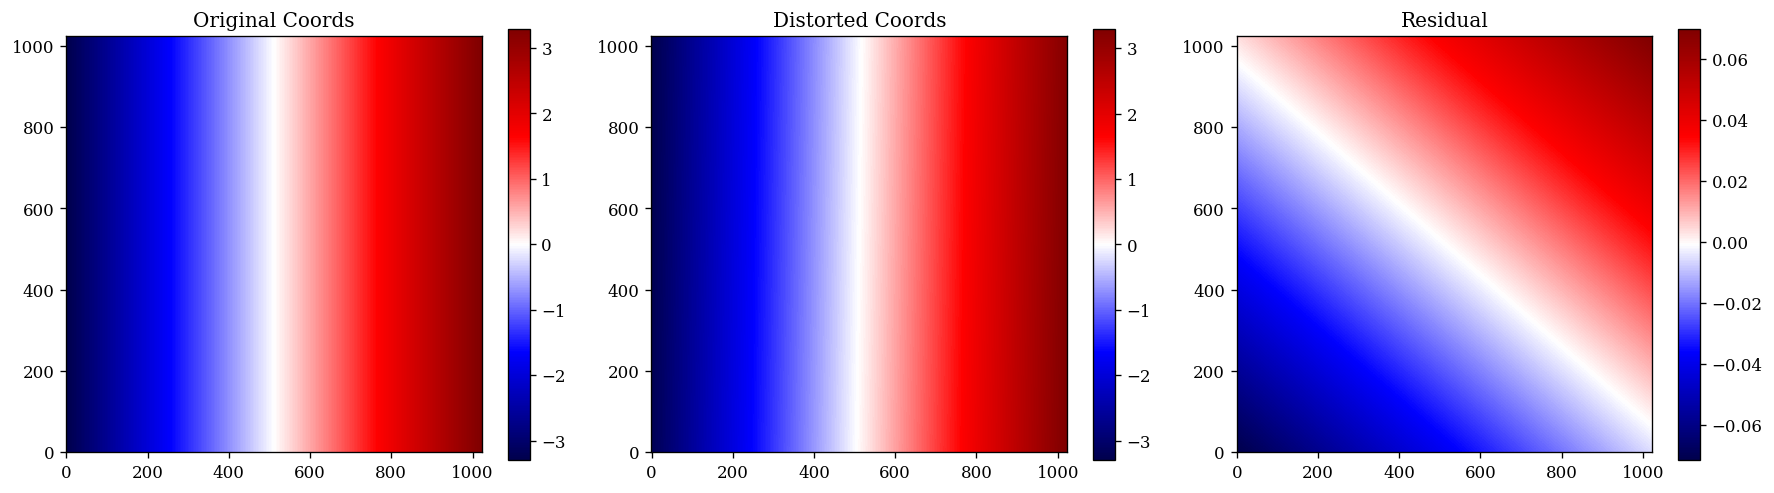

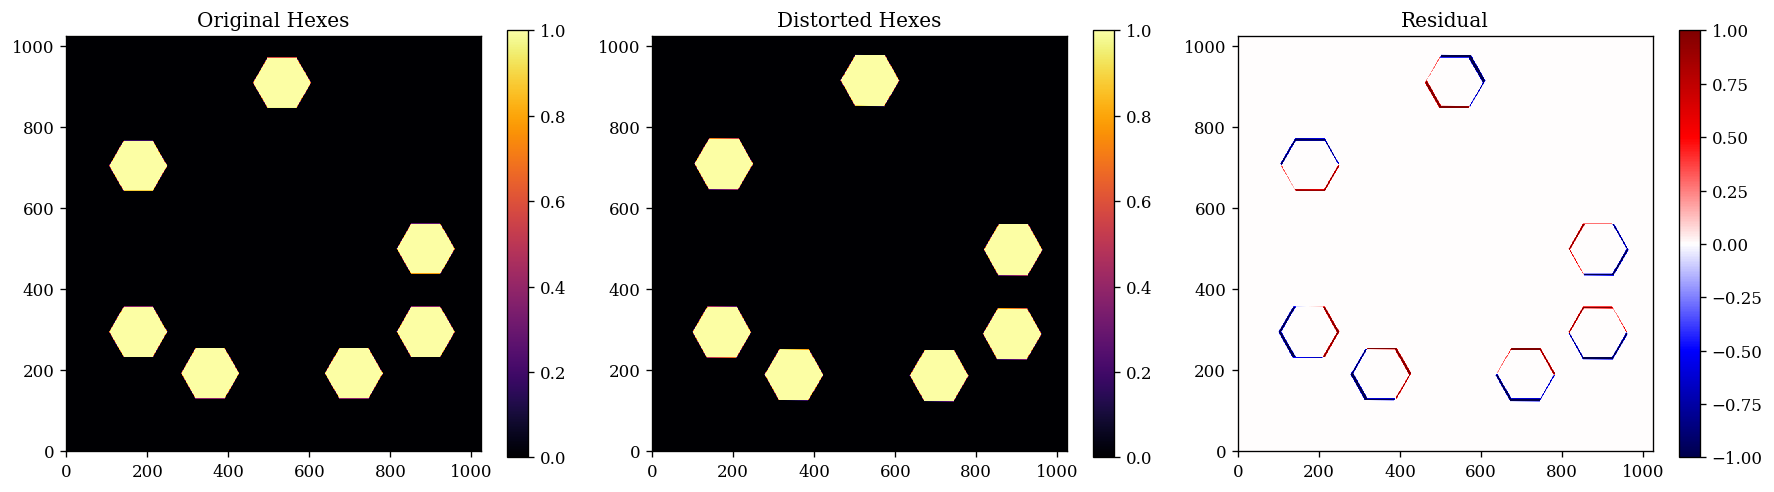

In [8]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Original Coords")
plt.imshow(coords[0], seismic)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Distorted Coords")
plt.imshow(distorted[0], seismic)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(coords[0] - distorted[0], seismic)
plt.colorbar()

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Original Hexes")
plt.imshow(hexes)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Distorted Hexes")
plt.imshow(distort_hexes)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(hexes - distort_hexes, seismic)
plt.colorbar()

plt.tight_layout()
plt.show()

In [9]:
from amigo.mask_models import DynamicAMIStaticAbb, calc_mask


def distort_coords(coords, coeffs, pows):
    pow_base = np.multiply(*(coords[:, None, ...] ** pows[..., None, None]))
    distortion = np.sum(coeffs[..., None, None] * pow_base[None, ...], axis=1)
    return coords + distortion


class PolyMask(DynamicAMIStaticAbb):
    distortion: np.ndarray
    powers: np.ndarray

    def __init__(self, *args, order=1, **kwargs):
        super().__init__(*args, **kwargs)
        self.powers = np.array(gen_powers(order + 1))[:, 1:]
        self.distortion = np.zeros_like(self.powers)

    def calc_mask(self, npixels, diameter):
        coords = dlu.pixel_coords(npixels, diameter)
        distorted_coords = distort_coords(coords, self.distortion, self.powers)
        hole_coords = vmap(dlu.translate_coords, (None, 0))(distorted_coords, self.holes)
        return calc_mask(hole_coords, self.f2f, diameter / npixels)

orig_mask = optics.pupil_mask
mask = PolyMask(order=3).set(
    ["abb_coeffs", "abb_basis"], [orig_mask.abb_coeffs, orig_mask.abb_basis]
)
model = model.set("pupil_mask", mask)

In [10]:
from amigo.fisher import calc_fishers

params = [
    "distortion",
]
ramp_model = model.ramp
model = model.set("ramp", None)
fishers = calc_fishers(model, exposures[:1], params, recalculate=True)
model = model.set("ramp", ramp_model)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2024-07-27 00:47:28.135647: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.70 = f64[7,1024,1024]{2,1,0} reduce(f64[7,6,1024,1024]{3,2,1,0} %broadcast.17, f64[] %constant.305), dimensions={1}, to_apply=%region_54.1657, metadata={op_name="jit(<unnamed wrapped function>)/jit(main)/jvp(transpose(jvp(jvp(jit(propagate)))))/reduce_sum[axes=(1,)]" source_file="/var/folders/28/6s47s91d14ldjdrljs4d1hxw0000gn/T/ipykernel_5475/2305258311.py" source_line=26}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-07-27 00:47:47.429468: E external/xla/xla/service/slow_operation_alarm.cc:13

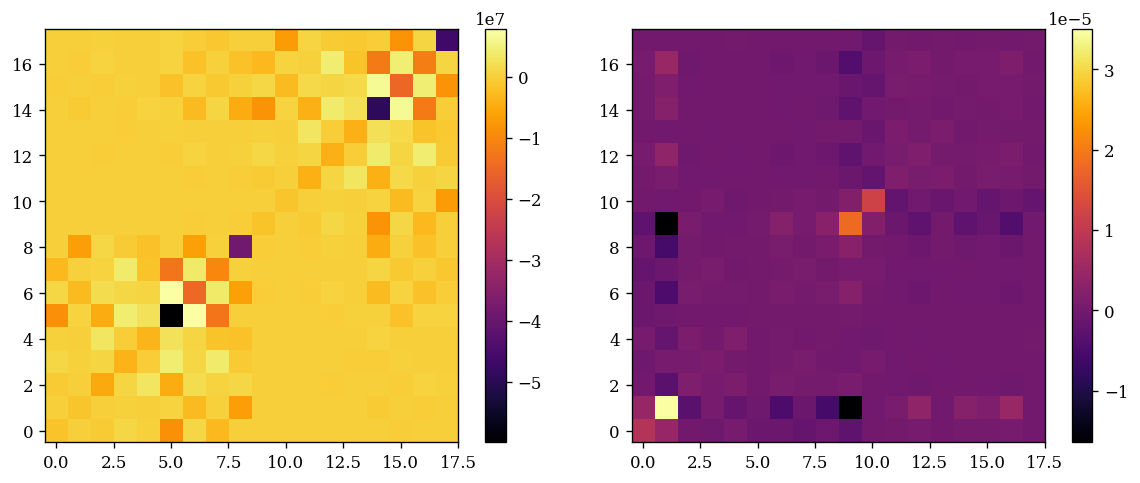

In [11]:
fmat = fishers["04481_001_04_3"]["distortion"]
cov_mat = - np.linalg.inv(fmat)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(fmat)
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(cov_mat)
plt.colorbar()

plt.tight_layout()
plt.show()